In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:

class CustomDataset(Dataset):
    def __init__(self, img_dir, mask_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.resize = resize
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.resize)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.resize)
        mask = (mask > 127).astype(np.uint8)  # binary: white -> 1, black -> 0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Add channel dimension: (1, H, W)

        return image, mask



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class PartialDecoder(nn.Module):
    def __init__(self, in_channels_list, num_classes, reduced_channels=64):
        super(PartialDecoder, self).__init__()
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_ch, reduced_channels, kernel_size=1)
            for in_ch in in_channels_list
        ])
        self.final_conv = nn.Conv2d(reduced_channels * len(in_channels_list), num_classes, kernel_size=3, padding=1)

    def forward(self, *features):
        target_size = features[0].shape[2:]
        outs = []
        for conv, f in zip(self.conv_layers, features):
            f_conv = conv(f)
            f_up = F.interpolate(f_conv, size=target_size, mode='bilinear', align_corners=True)
            outs.append(f_up)
        concat = torch.cat(outs, dim=1)
        seg_map = self.final_conv(concat)
        return seg_map

class ReverseAttention(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ReverseAttention, self).__init__()
        self.seg_proj = nn.Conv2d(num_classes, in_channels, kernel_size=1)
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=3, padding=1)

    def forward(self, high_level_feat, prev_seg_map, x_size):
        seg_proj = self.seg_proj(prev_seg_map)
        reverse_map = 1 - torch.sigmoid(seg_proj)
        attention = high_level_feat * reverse_map
        out_seg = self.conv(attention)
        refined_seg = prev_seg_map + out_seg
        refined_seg = F.interpolate(refined_seg, size=x_size, mode='bilinear', align_corners=True)
        return refined_seg

class PraNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(PraNet, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        self.pd = PartialDecoder(
            in_channels_list=[256, 512, 1024, 2048],
            num_classes=num_classes,
            reduced_channels=64
        )

        self.ra5 = ReverseAttention(in_channels=2048, num_classes=num_classes)
        self.ra4 = ReverseAttention(in_channels=1024, num_classes=num_classes)
        self.ra3 = ReverseAttention(in_channels=512, num_classes=num_classes)

    def forward(self, x):
        x_size = x.shape[2:]

        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        global_map = self.pd(enc2, enc3, enc4, enc5)

        ra5_in = F.interpolate(global_map, size=enc5.shape[2:], mode='bilinear', align_corners=True)
        refined5 = self.ra5(enc5, ra5_in, x_size)

        ra4_in = F.interpolate(refined5, size=enc4.shape[2:], mode='bilinear', align_corners=True)
        refined4 = self.ra4(enc4, ra4_in, x_size)

        ra3_in = F.interpolate(refined4, size=enc3.shape[2:], mode='bilinear', align_corners=True)
        final_pred = self.ra3(enc3, ra3_in, x_size)

        return final_pred
class StructureLoss(nn.Module):
    def __init__(self):
        super(StructureLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, pred, mask):
        pred = F.interpolate(pred, size=mask.shape[2:], mode='bilinear', align_corners=True)

        weit = 1 + 5 * torch.abs(F.avg_pool2d(mask.float(), kernel_size=31, stride=1, padding=15) - mask.float())
        bce = self.bce(pred, mask.float())
        bce = (weit * bce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

        pred_probs = torch.sigmoid(pred)
        inter = (pred_probs * mask).sum(dim=(2, 3))
        union = (pred_probs + mask).sum(dim=(2, 3))
        iou = 1 - (inter + 1) / (union - inter + 1)

        return (bce + iou).mean()


In [4]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


# ------------------- CONFIG -------------------
H, W = 480, 480
lr = 3e-4
batch_size = 16
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.4),
    A.RandomGamma(gamma_limit=(70, 130), p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ------------------- LOAD DATA -------------------
train_dataset = CustomDataset(
    img_dir='/kaggle/input/comvisdataprime/TrainDataset/TrainDataset/image',
    mask_dir='/kaggle/input/comvisdataprime/TrainDataset/TrainDataset/mask',
    resize=(H, W),
    transform=train_transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ------------------- TRAIN SETUP -------------------
model = PraNet(num_classes=1).to(device)
loss_fn = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)
loss_min = 1000
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device).float()

        optimizer.zero_grad()
        final_pred = model(images)
        loss = loss_fn(final_pred, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
    if epoch_loss<loss_min:
        torch.save(model.state_dict(), "/kaggle/working/bestNoDSV.pth")
        loss_min = epoch_loss
    scheduler.step(epoch_loss)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/model_weights_NoDSV.pth")

/tmp/ipykernel_31/1818398333.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/aaaaaa/pytorch/default/1/pranetbestNoDSV.pt

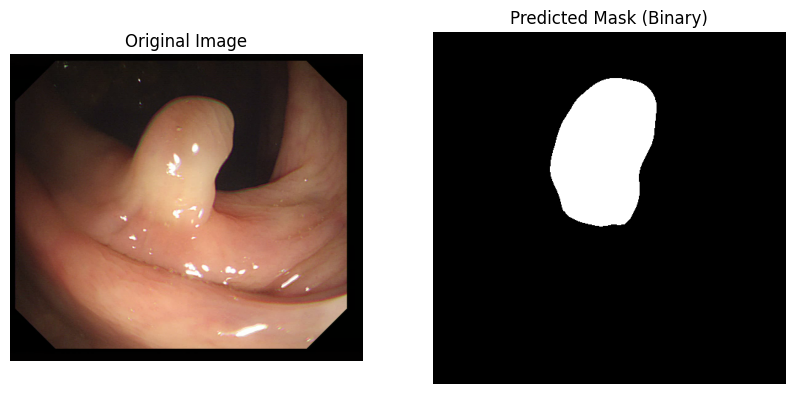

In [16]:

import matplotlib.pyplot as plt
device = 'cuda'
def infer(model, image_path, device, threshold=0.5):
    model.eval()

    # Load and preprocess image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed = A.Compose([
        A.Resize(480, 480),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])(image=image_rgb)

    input_tensor = transformed['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

        # Binary output: apply sigmoid and threshold
        prob_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        binary_mask = (prob_mask > threshold).astype(np.uint8) * 255  # foreground=255, background=0

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Predicted Mask (Binary)")
    plt.axis("off")
    plt.show()
model = PraNet(num_classes=1).to(device)
model.load_state_dict(torch.load("/kaggle/input/aaaaaa/pytorch/default/1/pranetbestNoDSV.pth", map_location=device))
model.eval()

infer(model, "/kaggle/input/comvisdataprime/TestDataset/TestDataset/CVC-300/images/149.png", device)


In [12]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

# === Dataset and Transforms ===
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Replace with your actual CustomDataset definition
test_dataset = CustomDataset(
    img_dir='/kaggle/input/comvisdataprime/TestDataset/TestDataset/CVC-300/images',
    mask_dir='/kaggle/input/comvisdataprime/TestDataset/TestDataset/CVC-300/masks',
    resize=(480, 480),
    transform=val_transform,
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# === Load Model ===
model = PraNet(num_classes=1)
model.load_state_dict(torch.load(
    "/kaggle/input/aaaaaa/pytorch/default/1/pranetbestNoDSV.pth",
    map_location='cuda' if torch.cuda.is_available() else 'cpu'
))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# === Metrics ===
def compute_iou(pred, mask, eps=1e-6):
    pred = (pred > 0.5).float()
    mask = (mask > 0.5).float()
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() - intersection
    return (intersection + eps) / (union + eps)

def compute_dice(pred, mask, eps=1e-6):
    pred = (pred > 0.5).float()
    mask = (mask > 0.5).float()
    intersection = (pred * mask).sum()
    return (2 * intersection + eps) / (pred.sum() + mask.sum() + eps)

# === Evaluation ===
ious, dices = [], []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        masks = masks.to(device).float()

        outputs = model(images)
        final_pred = outputs[0]  # only use the final refined output (side3)
        probs = torch.sigmoid(final_pred)

        for pred, true_mask in zip(probs, masks):
            iou = compute_iou(pred, true_mask)
            dice = compute_dice(pred, true_mask)
            ious.append(iou.item())
            dices.append(dice.item())

# === Results ===
macro_iou = np.mean(ious)
macro_dice = np.mean(dices)

print(f"📊 Macro IoU: {macro_iou:.4f}")
print(f"📊 Macro Dice: {macro_dice:.4f}")


/tmp/ipykernel_31/403578874.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(
Evaluating: 100%|██████████| 60/60 [00:01<00:00, 31.40it/s

📊 Macro IoU: 0.7966
📊 Macro Dice: 0.8737


In [7]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import numpy as np
from tqdm import tqdm
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# === Dataset Class ===
class CustomDataset(Dataset):
    def __init__(self, img_dir, mask_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.resize = resize
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.resize)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.resize)
        mask = (mask > 127).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # shape: (1, H, W)

        return image, mask

# === Transforms ===
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# === Dataset Setup ===
dataset_names = ['CVC-300', 'CVC-ClinicDB', 'CVC-ColonDB', 'ETIS-LaribPolypDB', 'Kvasir']
base_path = '/kaggle/input/comvisdataprime/TestDataset/TestDataset'

all_datasets = []
for name in dataset_names:
    img_dir = os.path.join(base_path, name, 'images')
    mask_dir = os.path.join(base_path, name, 'masks')
    ds = CustomDataset(img_dir=img_dir, mask_dir=mask_dir, resize=(480, 480), transform=val_transform)
    all_datasets.append(ds)

full_test_dataset = ConcatDataset(all_datasets)
test_loader = DataLoader(full_test_dataset, batch_size=1, shuffle=False)

# === Model Setup ===
model = PraNet(num_classes=1)
model.load_state_dict(torch.load("/kaggle/input/aaaaaa/pytorch/default/1/pranetbestNoDSV.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# === Metrics ===
def compute_iou(pred, mask, eps=1e-6):
    pred = (pred > 0.5).float()
    mask = (mask > 0.5).float()
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() - intersection
    return (intersection + eps) / (union + eps)

def compute_dice(pred, mask, eps=1e-6):
    pred = (pred > 0.5).float()
    mask = (mask > 0.5).float()
    intersection = (pred * mask).sum()
    return (2 * intersection + eps) / (pred.sum() + mask.sum() + eps)

# === Evaluation Loop ===
ious, dices = [], []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating All Datasets"):
        images = images.to(device)
        masks = masks.to(device).float()

        final_pred = model(images)
        probs = torch.sigmoid(final_pred)

        for pred, true_mask in zip(probs, masks):
            iou = compute_iou(pred, true_mask)
            dice = compute_dice(pred, true_mask)
            ious.append(iou.item())
            dices.append(dice.item())

# === Final Scores ===
macro_iou = np.mean(ious)
macro_dice = np.mean(dices)

print(f"📊 Macro IoU (All Datasets): {macro_iou:.4f}")
print(f"📊 Macro Dice (All Datasets): {macro_dice:.4f}")


/tmp/ipykernel_31/461992794.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/aaaaaa/pytorch/default/1/pranetbestNoDSV.pth

📊 Macro IoU (All Datasets): 0.6555
📊 Macro Dice (All Datasets): 0.7235
